In [0]:
try: 
    from google.colab import drive
    drive.mount('/content/drive')
    in_google_colab = True
    %tensorflow_version 1.x
except:
    in_google_colab = False

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print('Tensorflow version is {}'.format(tf.__version__))

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
TensorFlow 1.x selected.
Found GPU at: /device:GPU:0
Tensorflow version is 1.15.2


In [0]:
if in_google_colab:
    print("Currently in google colab, unpacking the files")
    !rm -r /content/mask_rcnn_envir
    !unzip /content/drive/'My Drive'/mask_rcnn_envir.zip  -d /content
    %cd mask_rcnn_envir/
else:
    print("Not in google colab")

Currently in google colab, unpacking the files
rm: cannot remove '/content/mask_rcnn_envir': No such file or directory
Archive:  /content/drive/My Drive/mask_rcnn_envir.zip
   creating: /content/mask_rcnn_envir/.ipynb_checkpoints/
  inflating: /content/mask_rcnn_envir/.ipynb_checkpoints/CA1 v1 Colab Version (edited, to 1 script, v2)-checkpoint.ipynb  
   creating: /content/mask_rcnn_envir/__pycache__/
  inflating: /content/mask_rcnn_envir/__pycache__/mask_rcnn_v2.cpython-36.pyc  
   creating: /content/mask_rcnn_envir/annotations/
  inflating: /content/mask_rcnn_envir/annotations/instances_openimagev5tococo_train2020.json  
  inflating: /content/mask_rcnn_envir/annotations/instances_openimagev5tococo_val2020.json  
  inflating: /content/mask_rcnn_envir/CA1 v1 - combined.ipynb  
  inflating: /content/mask_rcnn_envir/CA1 v1 Colab Version (edited, to 1 script, v2).ipynb  
  inflating: /content/mask_rcnn_envir/final_segmentation_metadata.csv  
  inflating: /content/mask_rcnn_envir/mask_rcnn

In [0]:
from mask_rcnn_v2 import Config, MaskRCNN, buildMASKRCNN, Dataset, CocoLikeDataset, display_top_masks, display_instances
import numpy as np
from numpy import zeros
from numpy import asarray
import colorsys
import argparse
import imutils
import random
import cv2
import os
import time
import json
from PIL import Image, ImageDraw
from matplotlib import pyplot
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from keras.models import load_model

from os import listdir
from xml.etree import ElementTree

from pycocotools import mask as maskUtils

from imgaug import augmenters as iaa

import pandas as pd

%matplotlib inline

Using TensorFlow backend.


In [0]:
class myMaskRCNNConfig(Config):
    NAME = 'MaskRCNN_config'
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    NUM_CLASSES = 3 + 1
    #self.IMAGE_META_SIZE = 1 + 3 + 3 + 4 + 1 + self.NUM_CLASSES
    
    STEPS_PER_EPOCH = 131

    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512     

    BACKBONE = 'resnet101'                       

    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256) 
    
    RPN_NMS_THRESHOLD = 0.8

    DETECTION_MIN_CONFIDENCE = 0.7

In [0]:
config = myMaskRCNNConfig()

In [0]:
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [0]:
dataset_train = CocoLikeDataset()
dataset_train.load_data('/content/mask_rcnn_envir/annotations/instances_openimagev5tococo_train2020.json', '/content/mask_rcnn_envir/openimagev5tococo_train2020')
dataset_train.prepare()

step 1: load json successfully
step 2: add class name successfully
step 3: get annotation successfully
step 4: get images successfully


In [0]:
dataset_val = CocoLikeDataset()
dataset_val.load_data('/content/mask_rcnn_envir/annotations/instances_openimagev5tococo_val2020.json', '/content/mask_rcnn_envir/openimagev5tococo_val2020')
dataset_val.prepare()

step 1: load json successfully
step 2: add class name successfully
step 3: get annotation successfully
step 4: get images successfully


In [0]:
dataset_train.class_names

['BG', 'Dress', 'Suit', 'Jeans']

In [0]:
dataset_val.class_names

['BG', 'Dress', 'Suit', 'Jeans']

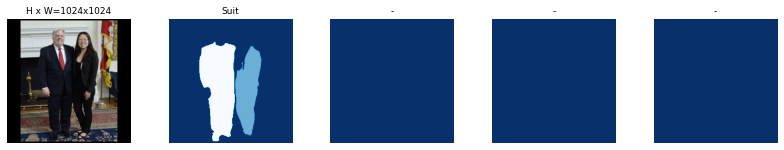

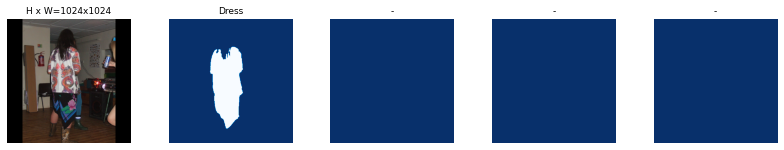

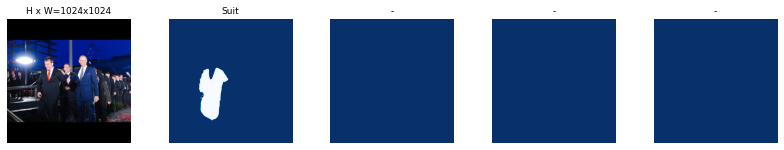

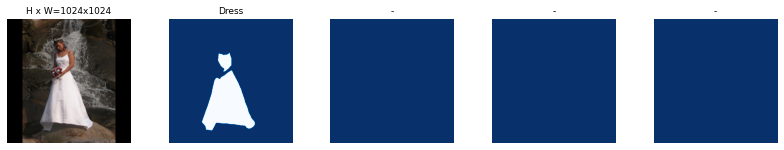

In [0]:
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    display_top_masks(image, mask, class_ids, dataset.class_names)

**IMAGE** AUGMENTATION

In [0]:
augmentation = iaa.Sequential([
    
    #brightness or contrast
    iaa.OneOf([
        iaa.Multiply((0.8, 1.2)), #(0.9, 1.1)),
        iaa.ContrastNormalization((0.8, 1.2)), #(0.9, 1.1)),
    ]),
    
])

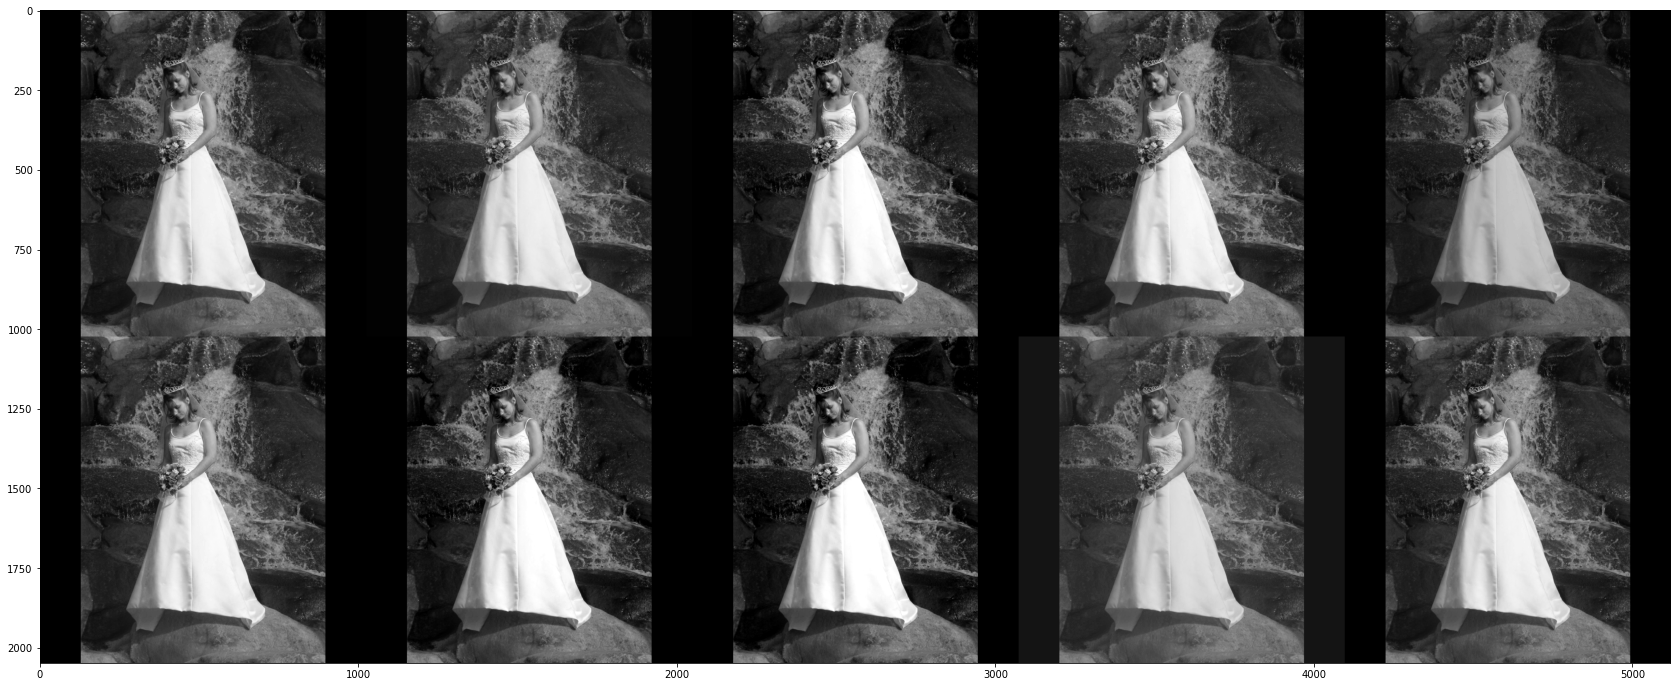

In [0]:
#test on the last image of the loop
imggrid = augmentation.draw_grid(image[:,:,0], cols=5, rows=2)
plt.figure(figsize=(30, 12))
_ = plt.imshow(imggrid[:,:,0], cmap='gray')

TRANSFER LEARNING ON MASK RCNN

In [0]:
model = buildMASKRCNN(config=config, model_dir="./")

#exclude the last few layers from training for ResNet101
#exclude the last layers is to match the number of classes in the new dataset
model.load_weights('./mask_rcnn_coco.h5', 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead








In [0]:
model.keras_model.summary()

Model: "mask_rcnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________

In [0]:
model.fit(dataset_train, dataset_val, 
            epochs=40, 
            learning_rate=config.LEARNING_RATE, 
            layers='heads'
            ,augmentation=augmentation
            )


Starting at epoch 0. LR=0.001

Checkpoint Path: ./maskrcnn_config20200407T1254/mask_rcnn_maskrcnn_config_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4   

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/40
131/131 [==============================] - 70s 535ms/step - loss: 10.9436 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 8.9937 - mrcnn_class_loss: 0.3106 - mrcnn_bbox_loss: 0.7963 - mrcnn_mask_loss: 0.8071 - val_loss: 10.8065 - val_rpn_class_loss: 0.0196 - val_rpn_bbox_loss: 9.3176 - val_mrcnn_class_loss: 0.1841 - val_mrcnn_bbox_loss: 0.6373 - val_mrcnn_mask_loss: 0.6479

Epoch 2/40
131/131 [==============================] - 33s 252ms/step - loss: 13.0483 - rpn_class_loss: 0.0311 - rpn_bbox_loss: 11.5217 - mrcnn_class_loss: 0.3197 - mrcnn_bbox_loss: 0.5319 - mrcnn_mask_loss: 0.6440 - val_loss: 6.6759 - val_rpn_class_loss: 0.0184 - val_rpn_bbox_loss: 4.9817 - val_mrcnn_class_loss: 0.2199 - val_mrcnn_bbox_loss: 0.8431 - val_mrcnn_mask_loss: 0.6128
Epoch 3/40
131/131 [==============================] - 33s 250ms/step - loss: 9.1757 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 7.7852 - mrcnn_class_loss: 0.2191 - mrcnn_bbox_loss: 0.5356 - mrcnn_mask_loss: 0.6139 - val_loss: 5.6110 - va

In [0]:
history = model.keras_model.history.history

Fine Tune ALL layers

In [0]:
model.fit(dataset_train, dataset_val, 
            epochs=60, 
            learning_rate=config.LEARNING_RATE, 
            layers='all'
            ,augmentation=augmentation
            )


Starting at epoch 40. LR=0.001

Checkpoint Path: ./maskrcnn_config20200407T1254/mask_rcnn_maskrcnn_config_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b   

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple 

Epoch 41/60
131/131 [==============================] - 101s 772ms/step - loss: 2.5033 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.8426 - mrcnn_class_loss: 0.1676 - mrcnn_bbox_loss: 0.2160 - mrcnn_mask_loss: 0.2645 - val_loss: 6.1910 - val_rpn_class_loss: 0.0100 - val_rpn_bbox_loss: 5.2998 - val_mrcnn_class_loss: 0.1204 - val_mrcnn_bbox_loss: 0.3337 - val_mrcnn_mask_loss: 0.4271
Epoch 42/60
131/131 [==============================] - 48s 367ms/step - loss: 4.3976 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 3.6761 - mrcnn_class_loss: 0.1888 - mrcnn_bbox_loss: 0.2302 - mrcnn_mask_loss: 0.2841 - val_loss: 5.5937 - val_rpn_class_loss: 0.0126 - val_rpn_bbox_loss: 4.6645 - val_mrcnn_class_loss: 0.1523 - val_mrcnn_bbox_loss: 0.3402 - val_mrcnn_mask_loss: 0.4241
Epoch 43/60
131/131 [==============================] - 48s 369ms/step - loss: 3.9197 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 3.2203 - mrcnn_class_loss: 0.1865 - mrcnn_bbox_loss: 0.2297 - mrcnn_mask_loss: 0.2680 - val_loss: 5.9831 - val_r

In [0]:
new_history = model.keras_model.history.history
for k in new_history:
    history[k] = history[k] + new_history[k]

In [0]:
import pandas as pd
epochs = range(1, len(next(iter(history.values())))+1)
pd.DataFrame(history, index=epochs)

val_loss  val_rpn_class_loss  ...  mrcnn_bbox_loss  mrcnn_mask_loss
1   10.806533            0.019627  ...         0.796275         0.807085
2    6.675915            0.018442  ...         0.531885         0.643957
3    5.611034            0.018384  ...         0.535620         0.613884
4    6.416351            0.015588  ...         0.469148         0.612170
5    6.902742            0.013903  ...         0.428485         0.580814
6    6.505699            0.015773  ...         0.354124         0.513732
7    5.358111            0.012034  ...         0.320775         0.470891
8    5.945611            0.011964  ...         0.353147         0.440275
9    5.787716            0.011430  ...         0.296766         0.419251
10   5.939788            0.010996  ...         0.272051         0.380005
11   6.959433            0.011957  ...         0.256398         0.371710
12   6.742080            0.011324  ...         0.267177         0.358191
13   5.945507            0.011783  ...         0.251457         0.356180
14   5.981597            0.011283  ...         0.254445         0.340033
15   5.914670            0.011514  ...         0.297642         0.333813
16   4.977466            0.011276  ...         0.283823         0.304192
17   4.892010            0.011185  ...         0.252360         0.330830
18   4.978249            0.010788  ...         0.200206         0.286279
19   4.290701            0.009307  ...         0.210211         0.300640
20   6.501644            0.012849  ...         0.226279         0.332715
21   5.273656            0.010508  ...         0.197477         0.294915
22   4.699166            0.012322  ...         0.242249         0.289800
23   4.552749            0.009452  ...         0.217877         0.304401
24   6.526082            0.013580  ...         0.229302         0.298136
25   3.872108            0.011569  ...         0.218604         0.327845
26   4.413810            0.011012  ...         0.179517         0.269577
27   4.903206            0.013154  ...         0.183121         0.263892
28   5.350375            0.012564  ...         0.178757         0.263772
29   5.009026            0.014408  ...         0.214873         0.294436
30   4.487823            0.010560  ...         0.207264         0.273460
31   5.131543            0.011879  ...         0.211538         0.328309
32   4.481758            0.012219  ...         0.200910         0.297342
33   5.352538            0.012405  ...         0.172730         0.256277
34   4.796953            0.013122  ...         0.160208         0.257456
35   4.857038            0.012262  ...         0.187733         0.319493
36   4.843267            0.010649  ...         0.166602         0.256523
37   5.200790            0.011094  ...         0.183968         0.240359
38   5.869516            0.011850  ...         0.177088         0.255241
39   6.445291            0.012166  ...         0.192806         0.244997
40   5.337807            0.012191  ...         0.191107         0.288388
41   6.191034            0.009967  ...         0.215990         0.264518
42   5.593742            0.012591  ...         0.230246         0.284141
43   5.983108            0.012655  ...         0.229683         0.267953
44   7.682796            0.011804  ...         0.223702         0.272943
45   5.817339            0.011890  ...         0.246571         0.258341
46   5.404694            0.011777  ...         0.231386         0.278828
47   4.547172            0.008919  ...         0.201268         0.268837
48   4.744385            0.009104  ...         0.199841         0.282587
49   6.571376            0.009847  ...         0.221970         0.286140
50   5.002583            0.009300  ...         0.215375         0.268424
51   6.024153            0.012570  ...         0.216717         0.249676
52   5.101948            0.010436  ...         0.199927         0.266344
53   5.318061            0.010448  ...         0.207410         0.253589
54   6.549013            0.012592  ...         0.166534        

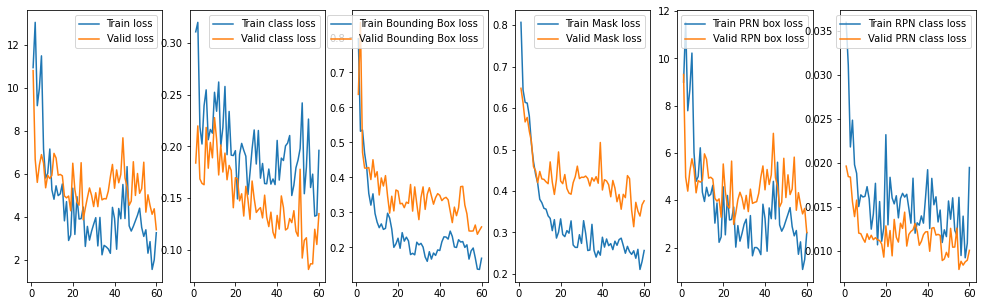

In [0]:
plt.figure(figsize=(17,5))

plt.subplot(161)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(162)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train class loss")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid class loss")
plt.legend()
plt.subplot(163)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train Bounding Box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid Bounding Box loss")
plt.legend()
plt.subplot(164)
plt.plot(epochs, history["mrcnn_mask_loss"], label="Train Mask loss")
plt.plot(epochs, history["val_mrcnn_mask_loss"], label="Valid Mask loss")
plt.legend()
plt.subplot(165)
plt.plot(epochs, history["rpn_bbox_loss"], label="Train PRN box loss")
plt.plot(epochs, history["val_rpn_bbox_loss"], label="Valid RPN box loss")
plt.legend()
plt.subplot(166)
plt.plot(epochs, history["rpn_class_loss"], label="Train RPN class loss")
plt.plot(epochs, history["val_rpn_class_loss"], label="Valid PRN class loss")
plt.legend()


plt.show()

In [0]:
best_epoch = np.argmin(history["val_loss"])
print("Best Epoch:", best_epoch + 1, history["val_loss"][best_epoch])

Best Epoch: 60 3.4113079428672792
